In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [22]:
def AlexNet(input_channel=3, class_num=2):
    model = nn.Sequential(
        nn.Conv2d(input_channel, 96, kernel_size=11, stride=4, padding=1),  # [3,224,224]-->[96,54,54]
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),  # [96,54,54]-->[96,26,26]
        nn.Conv2d(96, 256, kernel_size=5, padding=2),  # [96,26,26]-->[256,26,26]
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),  # [256,26,26]-->[256,12,12]
        nn.ReLU(),
        nn.Conv2d(256, 384, kernel_size=3, padding=1),  # [256,12,12]-->[384,12,12]
        nn.ReLU(),
        nn.Conv2d(384, 384, kernel_size=3, padding=1),  # [384,12,12]-->[384,12,12]
        nn.ReLU(),
        nn.Conv2d(384, 256, kernel_size=3, padding=1),  # [384,12,12]-->[]256,12,12]
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),  # [256,12,12]-->[256,5,5]
        nn.Flatten(),
        nn.Linear(6400, 4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096, class_num)
    )
    return model

In [50]:

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 第一个卷积层， 输入图像通道为3 , 输出的通道数为64 , 卷积核大小为3x3
        self.conv1 = nn.Conv2d(3, 64, 3, stride=2)
        # 第二个卷积层， 输入通道数为64 , 输出的通道数为128 , 卷积核大小为3x3
        self.conv2 = nn.Conv2d(64, 128, 3)
        # 第三个卷积层， 输入通道数为16 , 输出的通道数为3256 , 卷积核大小为3x3
        self.conv3 = nn.Conv2d(128, 256, 3)
        # 第一个全连接层
        self.fc1 = nn.Linear(256 * 12 * 12, 256)
        # 第二个全连接层
        self.fc2 = nn.Linear(256, 128)
        # 最后的全连接层，输出为2代表2分类
        self.fc3 = nn.Linear(128, 2)
    def forward(self, x):
        # 输入图像经过第一个卷积层卷积
        x = self.conv1(x)
        # 卷积后经过relu激活函数层
        x = F.relu(x)
        # 使用 2*2大小的 最大池化层进行池化
        x = F.max_pool2d(x, (2, 2))
        # 经过第二个卷积层卷积
        x = self.conv2(x)
        # 卷积后经过relu激活函数层
        x = F.relu(x)
        # 使用 2*2大小的 最大池化层进行池化
        x = F.max_pool2d(x, (2, 2))
        # 经过第三个卷积层卷积
        x = self.conv3(x)
        # 卷积后经过relu激活函数层
        x = F.relu(x)
        # 使用 2*2大小的 最大池化层进行池化
        x = F.max_pool2d(x, (2, 2))
        # 将卷积后的二维的特征图展开为一维向量用于全连接层的输入
        x = x.view(-1, self.num_flat_features(x))
        # 经过第一个全连接层和relu激活函数
        x = F.relu(self.fc1(x))
        # 经过第二个全连接层和relu激活函数
        x = F.relu(self.fc2(x))
        # 经过最终的全连接层分类
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:] 
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [23]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()

In [51]:
data_transforms = {
    # 训练中的数据增强和归一化
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # 随机裁剪
        transforms.RandomHorizontalFlip(), # 左右翻转
        transforms.ToTensor(),#转换为Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 均值方差归一化
    ]), 
    # 验证集不增强，仅进行归一化
    'val': transforms.Compose([
        #改变大小
        transforms.Resize(256),
        #设定中心大小
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = './datasets/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x])for x in ['train', 'val']}                                         
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=8)for x in ['train', 'val']}
            
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['ants', 'bees']


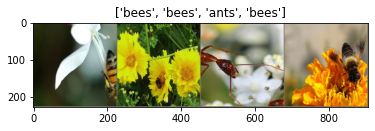

In [25]:
def imshow(inp, title=None):
    # 将输入的类型为torch.tensor的图像数据转为numpy的ndarray格式
    # 由于每个batch的数据是先经过transforms.ToTensor()函数从numpy的ndarray格式转换为torch.tensor格式，这个转换主要是通道顺序上做了调整：
    # 由原始的numpy中的BGR顺序转换为torch中的RGB顺序
    # 所以我们在可视化时候，要先将通道的顺序转换回来，即从RGB转回BGR
    inp = inp.numpy().transpose((1, 2, 0))
    # 接着再进行反归一化
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

#  从训练数据中取一个batch的图片
inputs, classes = next(iter(dataloaders['train']))
#拼成一幅画
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [26]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    #初始化网络权值
    best_model_wts = copy.deepcopy(model.state_dict())
    #最高的正确率
    best_acc = 0.0
    #训练次数
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 每一个epoch都会进行一次验证
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 设置模型为训练模式
            else:
                model.eval()   # 设置模型为验证模式

            running_loss = 0.0
            running_corrects = 0

            #  迭代所有样本
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 将梯度归零
                optimizer.zero_grad()

                # 前向传播网络，仅在训练状态记录参数的梯度从而计算loss
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #得到匹配率大的索引
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 反向传播来进行梯度下降更新权值
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # 统计loss值
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # 依据验证集的准确率来更新最优模型
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 载入最优模型
    model.load_state_dict(best_model_wts)

    return model



In [34]:
alexNet = AlexNet()
print(alexNet)
# 定义分类loss 
criterion = nn.CrossEntropyLoss()
# 优化器使用sgd，学习率设置为0.001
optimizer_ft = optim.SGD(alexNet.parameters(), lr=0.01, momentum=0.9)

# 每7个epoch将lr降低为原来的0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Sequential(
  (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): ReLU()
  (7): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): ReLU()
  (13): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Flatten(start_dim=1, end_dim=-1)
  (15): Linear(in_features=6400, out_features=4096, bias=True)
  (16): ReLU()
  (17): Dropout(p=0.5, inplace=False)
  (18): Linear(in_features=4096, out_features=4096, bias=True)
  (19): ReLU()
  (20): Dropout(p=0.5, inplace=False)
  (21): 

In [ ]:
alexNet = train_model(alexNet, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)         

In [52]:
net = Net()
print(net)
# 定义分类loss 
criterion = nn.CrossEntropyLoss()
# 优化器使用sgd，学习率设置为0.001
optimizer_ft = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 每7个epoch将lr降低为原来的0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
cnn_model = train_model(net, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25) 

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=36864, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)
Epoch 0/24
----------
train Loss: 0.6955 Acc: 0.4836
val Loss: 0.6860 Acc: 0.5425
Epoch 1/24
----------
train Loss: 0.6880 Acc: 0.5328
val Loss: 0.6823 Acc: 0.5948
Epoch 2/24
----------
train Loss: 0.6765 Acc: 0.5656
val Loss: 0.6753 Acc: 0.5817
Epoch 3/24
----------
train Loss: 0.6816 Acc: 0.5738
val Loss: 0.7116 Acc: 0.4641
Epoch 4/24
----------
train Loss: 0.6694 Acc: 0.5820
val Loss: 0.6774 Acc: 0.5817
Epoch 5/24
----------
train Loss: 0.6669 Acc: 0.5656
val Loss: 0.6646 Acc: 0.6013
Epoch 6/24
----------
train Loss: 0.6609 Acc: 0.6025
val Loss: 0.6587 Acc: 0.6078
Epoch 7/24
----------
train Loss: 0.6398 Acc: 0.

In [54]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

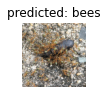

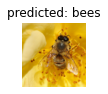

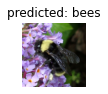

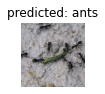

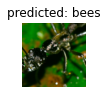

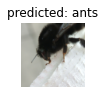

In [56]:
visualize_model(cnn_model)

In [53]:
#加载参数权重
net1=Net()
dict=torch.load('./data/model_parameter.pkl')
net1.load_state_dict(dict)
net1.eval()
print(net1)
visualize_model(net1)

FileNotFoundError: [Errno 2] No such file or directory: './data/model_parameter.pkl'

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

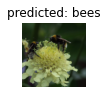

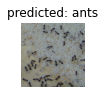

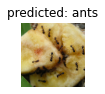

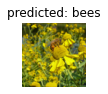

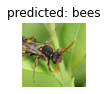

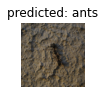

In [21]:
#加载整个模型
net2=torch.load('./data/model.pkl')
net2.eval()
print(net2)
visualize_model(net2)

In [60]:
# 从torchvision中载入resnet34模型，并且加载预训练
model_conv = torchvision.models.resnet34(pretrained=True)
# freeze前面的卷积层，使其训练时不更新
for param in model_conv.parameters():
    param.requires_grad = False

# 最后的分类fc层输出换为2，进行二分类
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 仅训练最后改变的fc层
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

print(model_conv)

d:\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [61]:
model_ft = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=25) 

Epoch 0/24
----------
train Loss: 0.6600 Acc: 0.6475
val Loss: 0.1897 Acc: 0.9281
Epoch 1/24
----------
train Loss: 0.5785 Acc: 0.7541
val Loss: 0.2129 Acc: 0.9150
Epoch 2/24
----------
train Loss: 0.5367 Acc: 0.7541
val Loss: 0.1686 Acc: 0.9216
Epoch 3/24
----------
train Loss: 0.2939 Acc: 0.8852
val Loss: 0.1469 Acc: 0.9346
Epoch 4/24
----------
train Loss: 0.4148 Acc: 0.8484
val Loss: 0.1280 Acc: 0.9542
Epoch 5/24
----------
train Loss: 0.3894 Acc: 0.8197
val Loss: 0.4509 Acc: 0.8235
Epoch 6/24
----------
train Loss: 0.5336 Acc: 0.7992
val Loss: 0.1526 Acc: 0.9412
Epoch 7/24
----------
train Loss: 0.3647 Acc: 0.8484
val Loss: 0.1446 Acc: 0.9542
Epoch 8/24
----------
train Loss: 0.3384 Acc: 0.8443
val Loss: 0.1464 Acc: 0.9542
Epoch 9/24
----------
train Loss: 0.2856 Acc: 0.8975
val Loss: 0.1455 Acc: 0.9542
Epoch 10/24
----------
train Loss: 0.2898 Acc: 0.8811
val Loss: 0.1563 Acc: 0.9542
Epoch 11/24
----------
train Loss: 0.3043 Acc: 0.8648
val Loss: 0.1618 Acc: 0.9412
Epoch 12/24
--

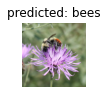

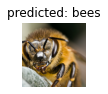

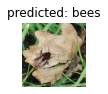

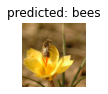

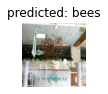

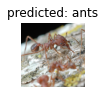

In [63]:
visualize_model(model_ft)